In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Question answering with Documents using Document AI, Pandas, and PaLM

> **NOTE:** This notebook uses the PaLM generative model, which will reach its [discontinuation date in October 2024](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text#model_versions). Please refer to [this updated notebook](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb) for a version which uses the latest Gemini model.

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/document-qa/question_answering_documentai_vector_store_palm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/use-cases/document-qa/question_answering_documentai_vector_store_palm.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/use-cases/document-qa/question_answering_documentai_vector_store_palm.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Holt Skinner](https://github.com/holtskinner), [Mona Mona](https://github.com/Mona19) |

## Overview

Question answering for large documents is a challenging task because it requires the ability to understand and process a large amount of text.
Question answering for large documents using Document AI and PaLM is a powerful approach that can be used to extract information from large amounts of text. Document AI can be used to extract structured data from documents, such as tables, lists, and images. PaLM can then be used to answer questions about the extracted data.

[Document AI](https://cloud.google.com/document-ai) provides a scalable and managed way to extract data from documents using AI. In this notebook, you will use the [Document OCR processor](https://cloud.google.com/document-ai/docs/document-ocr), which is a pre-trained model that will extract text and layout information from document files.

Here are some of the benefits of using Document AI and PaLM for question answering for large documents:

It can be used to extract information from a variety of document formats.
It can be used to answer questions about a variety of topics.
It can be used to answer questions in natural language.
It is a scalable solution that can be used to answer questions about large amounts of data.


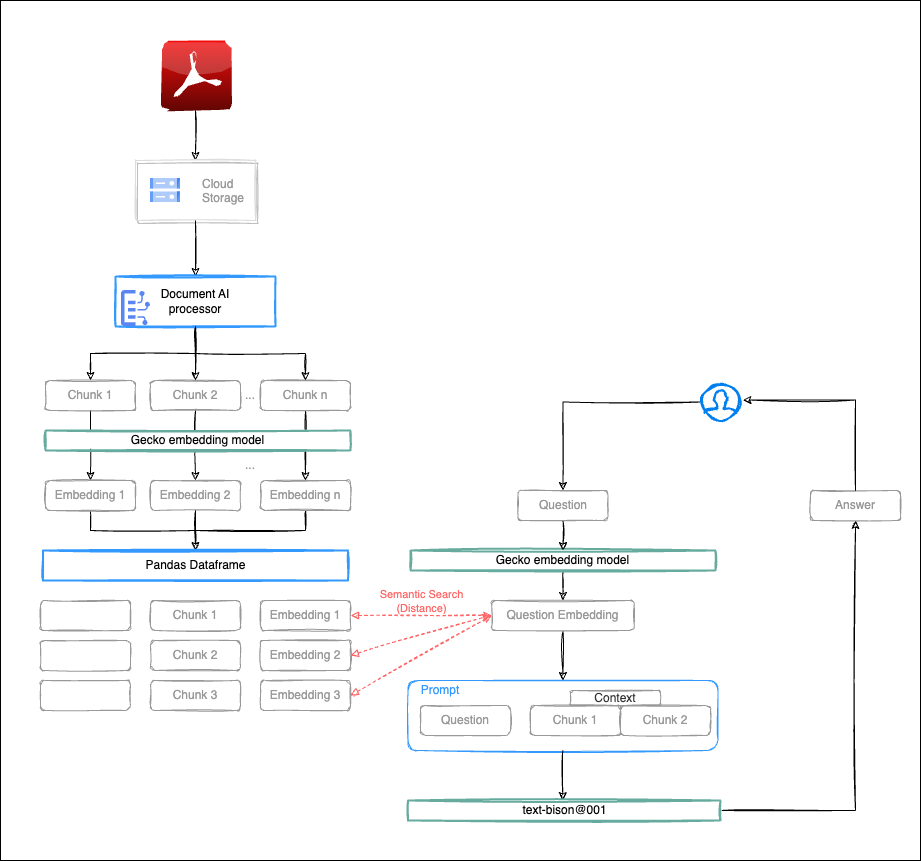


### Objective

In this notebook we will show how you can do the following:

1. Extract text from pdf documents using the Document AI OCR processor.
2. Use embedding model [Gecko](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings) to generate embeddings for the extracted text
3. Use PaLM `text-bison` model to answer questions on the embeddings datastore.


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI PaLM APIs offered by Generative AI studio
- Document AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
Learn about [Document AI pricing](https://cloud.google.com/document-ai/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK & Other dependencies


In [1]:
%pip install --upgrade google-cloud-aiplatform==1.35.0 google-cloud-documentai==2.20.1 backoff==2.2.1 --user

**Colab only**: Run the following cell to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.


In [ ]:
import sys

if "google.colab" in sys.modules:
    # Automatically restart kernel after installs so that your environment can access the new packages
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
else:
    # Otherwise, attempt to discover local credentials as described on https://cloud.google.com/docs/authentication/application-default-credentials
    pass

## Colab Only

You will need to run the following cell to authenticates your Colab environment with your Google Cloud account.


In [ ]:
if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Enable the APIs in your project


In [6]:
from __future__ import annotations
import backoff
from tenacity import retry, stop_after_attempt, wait_random_exponential
from google.api_core.exceptions import ResourceExhausted
from google.api_core.client_options import ClientOptions
from google.api_core.exceptions import AlreadyExists
from google.cloud import documentai
import numpy as np
import glob
import os
from typing import Dict, List
import pandas as pd
from logging import error
import re
import textwrap
from typing import Tuple, List
import vertexai
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel

In [ ]:
!gcloud config set project "YOUR_PROJECT_ID"

!gcloud services enable documentai.googleapis.com storage.googleapis.com aiplatform.googleapis.com

## Document AI

The following [limits](https://cloud.google.com/document-ai/quotas) apply for online processing with the Document OCR processor.

| Limit             | Value |
| ----------------- | ----: |
| Maximum file size | 20 MB |
| Maximum pages     |    15 |

For documents that don't meet these limits, you can use [batch processing](https://cloud.google.com/document-ai/docs/send-request#batch-process) to extract the document text. (Not covered in this notebook.)


### Preparing data files

To begin, you will need to download PDFs for the summarizing tasks below.
For this notebook, you will be using Alphabet earnings report PDFs hosted in a public Google Cloud Storage bucket.


In [2]:
# Copying the files from the GCS bucket to local storage
!gsutil -m cp -r gs://github-repo/documents/docai .

### Create Document AI OCR Processor

A [Document AI processor](https://cloud.google.com/document-ai/docs/overview#dai-processors) is an interface between a document file and a machine learning model that performs document processing actions. They can be used to classify, split, parse, or analyze a document. Each Google Cloud project needs to create its own processor instances.

There are two types of Document AI processors:

- Pre-trained processors: These processors are pre-trained on a large dataset of documents and can be used to perform common document processing tasks, such as Optical Character Recognition (OCR), form parsing, and entity extraction.
- Custom processors: These processors can be trained on your own dataset of documents to perform specific tasks that are not covered by the pre-trained processors.

Refer to [Full processor and detail list](https://cloud.google.com/document-ai/docs/processors-list) for all supported processors.

Processors take a PDF or image file as input and output the data in the [`Document`](https://cloud.google.com/document-ai/docs/reference/rest/v1/Document) format.


### Create a processor

Set these variables below:

1. Enter `YOUR_PROJECT_ID` in project_id
2. Enter `YOUR_PROCESSOR_DISPLAY_NAME` for `processor_display_name`. For example `processor_display_name = "my processor"`, before running the code below.

Note: Run this code only once to create the processor.
You cannot create multiple processors with the same display name. If you receive an error, change the name of the processor and rerun.


In [8]:
# TODO(developer): Edit these variables before running the code.
project_id = "YOUR_PROJECT_ID"

# See https://cloud.google.com/document-ai/docs/regions for all options.
location = "us"

# Must be unique per project, e.g.: "My Processor"
processor_display_name = "YOUR_PROCESSOR_DISPLAY_NAME"

# You must set the `api_endpoint` if you use a location other than "us".
client_options = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")


def create_processor(
    project_id: str, location: str, processor_display_name: str
) -> documentai.Processor:
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # The full resource name of the location
    # e.g.: projects/project_id/locations/location
    parent = client.common_location_path(project_id, location)

    # Create a processor
    return client.create_processor(
        parent=parent,
        processor=documentai.Processor(
            display_name=processor_display_name, type_="OCR_PROCESSOR"
        ),
    )


try:
    processor = create_processor(project_id, location, processor_display_name)
    print(f"Created Processor {processor.name}")
except AlreadyExists as e:
    print(
        f"Processor already exits, change the processor name and rerun this code. {e.message}"
    )

### Process the documents

Process document takes the processor name and file path of the document and extracts the text from the document.


In [9]:
def process_document(
    processor_name: str,
    file_path: str,
) -> documentai.Document:
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # Read the file into memory
    with open(file_path, "rb") as image:
        image_content = image.read()

    # Load Binary Data into Document AI RawDocument Object
    raw_document = documentai.RawDocument(
        content=image_content, mime_type="application/pdf"
    )

    # Configure the process request
    request = documentai.ProcessRequest(name=processor_name, raw_document=raw_document)

    result = client.process_document(request=request)

    return result.document

#### Create data chunks

LLMs produce the best results when documents text is broken up into small "chunks" before being added to the prompt.

Chunking is a technique used to break a document into smaller chunks that are easier to process. This can be done by dividing the document into sentences, paragraphs, or even sections.

The current token size limit for PaLM is 8196 tokens. This means that a single request to the PaLM API can only process a document that is up to 8196 tokens long. If the document is longer than this, it will need to be broken up into smaller chunks.

For the provided documents, we are using the paragraphs detected by Document AI to separate the chunks.
You should experiment with other values as well and see how it affects your summarization.


In [19]:
def layout_to_text(layout: documentai.Document.Page.Layout, text: str) -> str:
    """
    Document AI identifies text in different parts of the document by their
    offsets in the entirety of the document"s text. This function converts
    offsets to a string.
    """
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    return "".join(
        text[int(segment.start_index) : int(segment.end_index)]
        for segment in layout.text_anchor.text_segments
    )


# If you already have a Document AI Processor in your project, assign the full processor resource name here.
processor_name = processor.name
chunk_size = 5000
extracted_data: List[Dict] = []

# Loop through each PDF file in the "docai" directory.
for path in glob.glob("docai/*.pdf"):
    # Extract the file name and type from the path.
    file_name, file_type = os.path.splitext(path)

    print(f"Processing {file_name}")

    # Process the document.
    document = process_document(processor_name, file_path=path)

    if not document:
        print("Processing did not complete successfully.")
        continue

    # Split the text into chunks based on paragraphs.
    document_chunks = [
        layout_to_text(paragraph.layout, document.text)
        for page in document.pages
        for paragraph in page.paragraphs
    ]

    # Can also split into chunks by page or blocks.
    # document_chunks = [page.text for page in wrapped_document.pages]
    # document_chunks = [block.text for page in wrapped_document.pages for block in page.blocks]

    # Loop through each chunk and create a dictionary with metadata and content.
    for chunk_number, chunk_content in enumerate(document_chunks, start=1):
        # Append the chunk information to the extracted_data list.
        extracted_data.append(
            {
                "file_name": file_name,
                "file_type": file_type,
                "chunk_number": chunk_number,
                "content": chunk_content,
            }
        )

In [20]:
# Convert extracted_data to a sorted Pandas DataFrame
pdf_data = (
    pd.DataFrame.from_dict(extracted_data)
    .sort_values(by=["file_name"])
    .reset_index(drop=True)
)

pdf_data.head()

In [ ]:
# Define the maximum number of characters in each chunk.
chunk_size = 5000

pdf_data_sample = pdf_data.copy()

# Remove all non-alphabets and numbers from the data to clean it up.
# This is harsh cleaning. You can define your custom logic for cleansing here.
pdf_data_sample["content"] = pdf_data_sample["content"].apply(
    lambda x: re.sub("[^A-Za-z0-9]+", " ", x)
)

# Apply chunk splitting logic to each row of content in the DataFrame.
pdf_data_sample["chunks"] = pdf_data_sample["content"].apply(
    lambda row: textwrap.wrap(row, width=chunk_size)
)

# Now, each row in 'chunks' contains list of all chunks and hence we need to explode them into individual rows.
pdf_data_sample = pdf_data_sample.explode("chunks")

# Sort and reset index
pdf_data_sample = pdf_data_sample.sort_values(by=["file_name"]).reset_index(drop=True)
pdf_data_sample.head()

In [ ]:
print("The original dataframe has :", pdf_data.shape[0], " rows without chunking")
print("The chunked dataframe has :", pdf_data_sample.shape[0], " rows with chunking")

## Question Answering using the [PaLM](https://ai.google/discover/palm2/) and Gecko Embedding model

You have just used Document AI to extract text from PDF files.

In the next section, you will perform question answering on the extracted text using the PaLM model and Gecko Embedding model with Vertex AI.

Question answering using PaLM model and Gecko embedding model is a technique that can be used to improve the accuracy and efficiency of question answering.

The Gecko embedding model is a pre-trained embedding model that has been trained on a large dataset of text. It can be used to represent text as vectors that can be used to measure the similarity between different pieces of text.

The PaLM model is a large language model that has been trained on a massive dataset of text and code. It can be used to answer questions in a variety of ways, including factual question answering, open-ended question answering, and answering questions in context.

To use the PaLM model and Gecko embedding model for question answering, you can use the following steps:

1. Represent the documents that contain the answer as vectors using the Gecko embedding model.
2. Compare the question to the document vector store.
3. The document with the most similar vector to the question is the document that contains the answer.


### Authenticating your notebook environment

- If you are using **Colab** to run this notebook, run the cell below and continue.
- If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).


In [ ]:
PROJECT_ID = ""  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

### Import models


In [22]:
generation_model = TextGenerationModel.from_pretrained("text-bison")
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")


# This decorator is used to handle exceptions and apply exponential backoff in case of ResourceExhausted errors.
# It means the function will be retried with increasing time intervals in case of this specific exception.
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(5))
def text_generation_model_with_backoff(**kwargs):
    return generation_model.predict(**kwargs).text


@retry(wait=wait_random_exponential(min=10, max=120), stop=stop_after_attempt(5))
def embedding_model_with_backoff(text=[]):
    embeddings = embedding_model.get_embeddings(text)
    return [each.values for each in embeddings][0]

You can start the implementation first by simply getting the embeddings for each chunk.

This will add the embeddings (vector/number representation) of each chunk as a separate column.


In [23]:
pdf_data_sample["embedding"] = pdf_data_sample["chunks"].apply(
    lambda x: embedding_model_with_backoff([x])
)
pdf_data_sample["embedding"] = pdf_data_sample.embedding.apply(np.array)
pdf_data_sample.head(2)

In [ ]:
def get_context_from_question(
    question: str, vector_store: pd.DataFrame, sort_index_value: int = 2
) -> Tuple[str, pd.DataFrame]:
    query_vector = np.array(embedding_model_with_backoff([question]))
    vector_store["dot_product"] = vector_store["embedding"].apply(
        lambda row: np.dot(row, query_vector)
    )
    top_matched = vector_store.sort_values(by="dot_product", ascending=False)[
        :sort_index_value
    ].index
    top_matched_df = vector_store.loc[top_matched, ["file_name", "chunks"]]
    context = "\n".join(top_matched_df["chunks"].values)
    return context, top_matched_df

Now that you have a general function that always gets you custom relevant context for the question, you can call it with every new question.


In [ ]:
%%time
# your question for the documents
question = "When did google become carbon neutral?"

# get the custom relevant chunks from all the chunks in vector store.
context, top_matched_df = get_context_from_question(
    question,
    vector_store=pdf_data_sample,
    sort_index_value=2,  # Top N results to pick from embedding vector search
)
# top 5 data that has been picked by model based on user question. This becomes the context.
top_matched_df

In [ ]:
# Prompt for Q&A which takes the custom context found in last step.
prompt = f""" Answer the question as precise as possible using the provided context. \n\n
            Context: \n {context}?\n
            Question: \n {question} \n
            Answer:
          """

# Call the PaLM API on the prompt.
print("PaLM Predicted:", text_generation_model_with_backoff(prompt=prompt), "\n\n")

# Conclusion

In this notebook, you learned:

1. Extract text from pdf documents using the Document AI OCR processor.
2. Use Embedding model Gecko to generate embeddings for the extracted text
3. Use PaLM chat-bison@latest model to answer questions on the embeddings datastore.


## Clean Up

If you no longer need the Document AI processor, you can delete it using the following code.

Alternatively, you can use the Cloud Console to delete the processor as outlined in [Creating and managing processors > Delete a processor](https://cloud.google.com/document-ai/docs/create-processor#documentai_delete_processor-web).


In [ ]:
def delete_processor(processor_name: str) -> None:
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # Delete a processor
    operation = client.delete_processor(name=processor_name)
    # Print operation details
    print(operation.operation.name)
    # Wait for operation to complete
    operation.result()


delete_processor(processor_name)